### Downloading Libraries

In [1]:
!pip install numpy==1.26.4
#!pip install pandas==2.1.3 # Sometimes this lines needs to be excluded when there are problems loading libraries and sometimes needs to be included
!pip install spacy==3.7.4
!pip install gensim==4.3.3
!pip install tweet-preprocessor==0.6.0

### Importing Libraries

In [2]:
import numpy as np
import pandas as pd
import preprocessor as p
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import nltk
import re
import spacy
import plotly.express as px
import plotly.graph_objects as go
# Importing gensim and related libraries
import gensim

from gensim import models
from gensim.utils import simple_preprocess
from gensim.models.phrases import Phrases

import gensim.corpora as corpora

from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel

from nltk.sentiment.vader import SentimentIntensityAnalyzer

from wordcloud import WordCloud
from IPython.display import display, HTML
from collections import Counter
#from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from google.colab import drive
nltk.download('stopwords')
nltk.download('popular')
nltk.download('punkt_tab')
nltk.download('vader_lexicon')
pd.set_option('display.expand_frame_repr', False)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data] 

### Loading Data

In [3]:
drive.mount('/content/drive')
adidas_df_base = pd.read_csv('/content/drive/MyDrive/Docs/adidas_tweets.csv')
lululemon_df_base = pd.read_csv('/content/drive/MyDrive/Docs/lululemon_tweets.csv')
print(adidas_df_base.shape)
print(lululemon_df_base.shape)

Mounted at /content/drive
(38212, 15)
(6190, 15)


### EDA

In [4]:
print(adidas_df_base.head())
print(lululemon_df_base.head())

                  created_at                   id                                          full_text  is_quote_status  retweet_count  favorite_count             user.id        user.name user.screen_name             user.location  user.followers_count  user.friends_count  user.listed_count  user.verified  user.statuses_count
0  2021-10-01 07:37:16+00:00  1443842433641558000  @_christiankeith @d1vetsam @KicksFinder They a...            False              0               0  723347581586255900             Nate        NateRuns5                       NaN                   117                 240                  0          False                11259
1  2021-10-01 11:00:25+00:00  1443893560680456200  SELENA boosted up Puma stocks by 40%  Her part...            False              0               0           281283506    La Revelacion   BoysRevelacion                       NaN                   790                 324                  4          False                90265
2  2021-10-01 07:13:08

In [5]:
print(adidas_df_base.info())
print(lululemon_df_base.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38212 entries, 0 to 38211
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   created_at            38212 non-null  object
 1   id                    38212 non-null  int64 
 2   full_text             38212 non-null  object
 3   is_quote_status       38212 non-null  bool  
 4   retweet_count         38212 non-null  int64 
 5   favorite_count        38212 non-null  int64 
 6   user.id               38212 non-null  int64 
 7   user.name             38212 non-null  object
 8   user.screen_name      38212 non-null  object
 9   user.location         27778 non-null  object
 10  user.followers_count  38212 non-null  int64 
 11  user.friends_count    38212 non-null  int64 
 12  user.listed_count     38212 non-null  int64 
 13  user.verified         38212 non-null  bool  
 14  user.statuses_count   38212 non-null  int64 
dtypes: bool(2), int64(8), object(5)
memo

In [8]:
# Tweets Date Range
adidas_date_range = (
    pd.to_datetime(adidas_df_base['created_at']).min().strftime('%Y-%m-%d'),
    pd.to_datetime(adidas_df_base['created_at']).max().strftime('%Y-%m-%d')
)
lululemon_date_range = (
    pd.to_datetime(lululemon_df_base['created_at']).min().strftime('%Y-%m-%d'),
    pd.to_datetime(lululemon_df_base['created_at']).max().strftime('%Y-%m-%d')
)

print("Adidas Tweet Date Range:", adidas_date_range)
print("Lululemon Tweet Date Range:", lululemon_date_range)

Adidas Tweet Date Range: ('2021-10-01', '2022-01-01')
Lululemon Tweet Date Range: ('2021-10-01', '2022-01-01')


In [9]:
# Number of unique users
print(f"Percentage of unique users in Adidas dataset: {round(adidas_df_base['user.screen_name'].nunique()*100/len(adidas_df_base),1)}")
print(f"Percentage of unique users in Lululemon dataset: {round(lululemon_df_base['user.screen_name'].nunique()*100/len(lululemon_df_base),1)}")

Percentage of unique users in Adidas dataset: 76.3
Percentage of unique users in Lululemon dataset: 72.1


In [10]:
def screen_name_id_consistency(df):
    user_id_screen_name_mapping = df.groupby('user.id')['user.screen_name'].nunique()
    inconsistent_ids = user_id_screen_name_mapping[user_id_screen_name_mapping > 1].count()
    return inconsistent_ids

# Evaluate for Adidas
adidas_inconsistent_ids = screen_name_id_consistency(adidas_df_base)
print(f"Number of user IDs with different screen names in Adidas dataset: {adidas_inconsistent_ids}")

# Evaluate for Lululemon
lululemon_inconsistent_ids = screen_name_id_consistency(lululemon_df_base)
print(f"Number of user IDs with different screen names in Lululemon dataset: {lululemon_inconsistent_ids}")

Number of user IDs with different screen names in Adidas dataset: 0
Number of user IDs with different screen names in Lululemon dataset: 0


In [11]:
print(f"Percentage of verified users in Adidas: {round(adidas_df_base[adidas_df_base['user.verified'] == True]['user.screen_name'].nunique()*100/adidas_df_base['user.screen_name'].nunique(),1)}%")
print(f"Percentage of verified users in Lululemon: {round(lululemon_df_base[lululemon_df_base['user.verified'] == True]['user.screen_name'].nunique()*100/lululemon_df_base['user.screen_name'].nunique(),1)}%")

Percentage of verified users in Adidas: 1.8%
Percentage of verified users in Lululemon: 4.2%


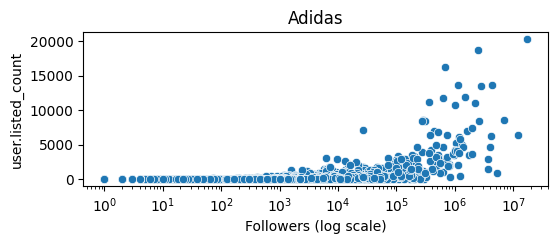

In [12]:
def analyze_user_data(df,column,title):
    # Group by user.screen_name and calculate the average of specified columns
    grouped_df = df.groupby('user.screen_name').agg({
        'user.followers_count': 'mean',
        column: 'mean'
    }).reset_index()

    # Create a scatter plot
    plt.figure(figsize=(6, 2))
    sns.scatterplot(x='user.followers_count', y=column, data=grouped_df)
    plt.xscale('log')
    plt.xlabel('Followers (log scale)')
    plt.title(title)
    plt.show()

analyze_user_data(adidas_df_base,'user.listed_count',title='Adidas')

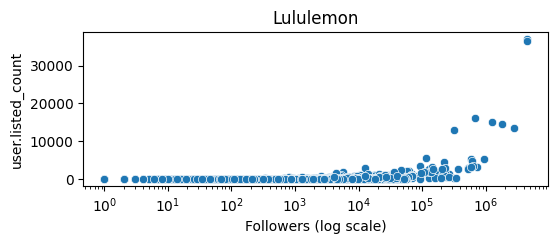

In [13]:
analyze_user_data(lululemon_df_base,'user.listed_count',title='Lululemon')

In [14]:
def plot_user_engagement(df, title):
    grouped_df = df.groupby('user.screen_name').agg({
        'user.followers_count': 'mean',
        'user.statuses_count': 'mean'
    }).reset_index()

    # Create a scatter plot
    plt.figure(figsize=(6, 2))
    sns.scatterplot(x='user.followers_count', y='user.statuses_count', data=grouped_df)
    plt.xscale('log')  # Use log scale for better visualization of follower counts
    plt.yscale('log')  # Use log scale for better visualization of statuses count
    plt.xlabel('Followers Count (log scale)')
    plt.ylabel('Statuses Count (log scale)')
    plt.title(title)
    plt.show()

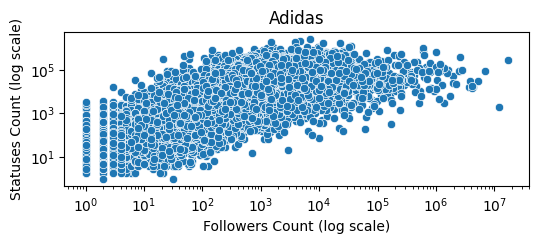

In [15]:
plot_user_engagement(adidas_df_base, title='Adidas')

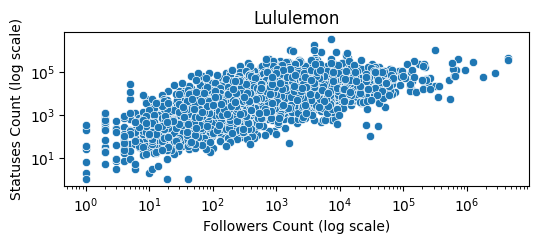

In [16]:
plot_user_engagement(lululemon_df_base, title='Lululemon')

## SOCIAL NETWORK ANALYSIS

### Creating the Graph

In [17]:
# ================== Function to build a DataFrame of mentions ======================
def build_mention_edges(df):
    # Removing outliers
    df = df[df['user.followers_count']<=df['user.followers_count'].mean() + 3*df['user.followers_count'].std()]
    rows = []

    for _, row in df.iterrows():
        from_user = row['user.screen_name']
        mentions = re.findall(r'@(\w+)', row['full_text'])
        # Eliminating adidas or lululemon accounts
        filtered_mentions = [m for m in mentions if 'adidas' not in m.lower() and 'lululemon' not in m.lower()]
        for to_user in filtered_mentions:
            rows.append({'From': from_user, 'To': to_user})

    df_edges = pd.DataFrame(rows)
    return df_edges
# Creating te DataFrames
adidas_interactions = build_mention_edges(adidas_df_base)
lululemon_interactions = build_mention_edges(lululemon_df_base)

G_adidas_interactions = nx.from_pandas_edgelist(adidas_interactions, source='From', target='To', create_using=nx.DiGraph())
G_lululemon_interactions = nx.from_pandas_edgelist(lululemon_interactions, source='From', target='To', create_using=nx.DiGraph())

### Creating a list of most mentioned users in the network based on in-degree centrality

In [18]:
# ============ Function to show Top 10 user with highest in-degree ====================
def calculate_in_degree(graph):
    in_degree_dict = dict(graph.in_degree())
    in_degree_df = pd.DataFrame({'User': list(in_degree_dict.keys()), 'In-degree': list(in_degree_dict.values())})
    return in_degree_df.sort_values('In-degree', ascending=False).head(10)

adidas_in_degree = calculate_in_degree(G_adidas_interactions)
lululemon_in_degree = calculate_in_degree(G_lululemon_interactions)

# Create HTML for thetables
html_string = '''
<div style="display: flex;">
  <div style="flex: 1; margin-right: 20px;">
    <h3>Adidas Top 10 In-Degrees</h3>
    {adidas_table}
  </div>
  <div style="flex: 1;">
    <h3>Lululemon Top 10 In-Degrees</h3>
    {lululemon_table}
  </div>
</div>
'''
html_string = html_string.format(adidas_table=adidas_in_degree.to_html(), lululemon_table=lululemon_in_degree.to_html())

# Display the HTML
display(HTML(html_string))

,User,In-degree
1181,Xbox,7428
3134,AustinEkeler,6938
5,Nike,1817
10792,Hyperkin,986
19601,BoredApeYC,624
20606,richsignorelli,416
1434,DashieXP,344
3355,Michael_Fabiano,339
1033,spidadmitchell,289
9974,EASPORTSFIFA,285


Most mentioned users related to Adidas include large corporate and entertainment accounts such as Xbox, Nike, Easportsfifa, Hyperkin and the Adidas itself. Also, celebrities, athletes and influencers linked to technology. This suggests that conversations around Adidas on Twitter are driven by famous accounts across sports, gaming, and digital culture.
For Lululemon, the most frequently mentioned users include social campaigns and organizations such as TeamCanada, CDNParalympics and public figures like Calvin Mcdonald. Fitness and wellness brands such as onepeloton also appear in the top mentions. These users indicate a conversation that is more centered on wellness, social responsibility, and national identity.

In [19]:
# ============ Function to create a DataFrame with structure metrics of a sample ===============
def get_structural_metrics(graph, sample_size):
    in_degree_centrality = nx.in_degree_centrality(graph)
    sorted_degree = sorted(in_degree_centrality.items(), key=lambda item: item[1], reverse=True)
    sampled_nodes = [node for node, _ in sorted_degree[:sample_size]]

    # Subgraph with top nodes only
    subgraph = graph.subgraph(sampled_nodes)

    # Compute metrics on subgraph only once
    in_degree = nx.in_degree_centrality(subgraph)
    betweenness = nx.betweenness_centrality(subgraph)
    closeness = nx.closeness_centrality(subgraph)

    metrics_df = pd.DataFrame(index=sampled_nodes)
    metrics_df['In-Degree'] = [in_degree[node] for node in sampled_nodes]
    metrics_df['Betweenness'] = [betweenness[node] for node in sampled_nodes]
    metrics_df['Closeness'] = [closeness[node] for node in sampled_nodes]
    # Filtering those influencers with betweenness equal to 0
    metrics_df = metrics_df[metrics_df['Betweenness']>0].copy()
    # Standarizing metrics for the score calculation
    scaler = StandardScaler()
    scaled_values = scaler.fit_transform(metrics_df[['Betweenness', 'Closeness', 'In-Degree']])
    scaled_df = pd.DataFrame(scaled_values, index=metrics_df.index, columns=['Betweenness', 'Closeness', 'In-Degree'])
    # Calculating Influencer Score
    metrics_df['Influencer Score'] = (
        2.5 * scaled_df['Betweenness'] +
        2.5 * scaled_df['Closeness'] +
        2 * scaled_df['In-Degree']
    )

    return metrics_df

adidas_structural_metrics = get_structural_metrics(G_adidas_interactions, 4000)
lululemon_structural_metrics = get_structural_metrics(G_lululemon_interactions, 2000)

Justification for the Selection of Structural Metrics

The purpose of this analysis is to identify influencers who are not only popular, but also relationally and structurally relevant. In the current post-advertising environment, the focus has shifted from mass communication to authentic and meaningful connections within social networks. For this reason, four structural metrics have been selected:

**Betweenness centrality** helps to detect users who connect different parts of the network. These individuals often act as bridges between communities and can influence how messages travel across the network.

**Closeness centrality** shows how quickly a user can reach other users in the network. A high value suggests that the user is well-positioned to spread content efficiently and naturally.

**In-Degree centrality** is included with a lower weight because it reflects direct interactions. While it does not always indicate meaningful influence,  it can still provide useful information about how often a person is mentioned by others in the network.

By combining these metrics, it is possible to identify users who are structurally important, well-connected, and potentially more influential.

In [20]:
# ============ Function to get followers, friends, listed_count and verified of each user ====================
def general_metrics(df):
  cols_to_average = ['user.listed_count', 'user.followers_count', 'user.friends_count','user.statuses_count']
  cols_present = [col for col in cols_to_average if col in df.columns]
  grouped_df = df.groupby('user.screen_name')[cols_present].mean()
  grouped_df.columns = ['user.listed_count', 'user.followers_count', 'user.friends_count','user.statuses_count']
  verified_status = df.groupby('user.screen_name')['user.verified'].first() # Take the first value for each user
  grouped_df['user.verified'] = verified_status
  grouped_df.columns = ['listed','followers','friends','publications','verified']

  return grouped_df

adidas_general_metrics = general_metrics(adidas_df_base)
lululemon_general_metrics = general_metrics(lululemon_df_base)

merged_adidas = pd.merge(adidas_structural_metrics, adidas_general_metrics, left_index=True, right_index=True, how='inner')
merged_lululemon = pd.merge(lululemon_structural_metrics, lululemon_general_metrics, left_index=True, right_index=True, how='inner')

print(merged_adidas.sort_values(by='Influencer Score',ascending=False).head(10))
print(merged_lululemon.sort_values(by='Influencer Score',ascending=False).head(10))

                In-Degree  Betweenness  Closeness  Influencer Score  listed      followers      friends   publications  verified
turtlepace5      0.004751     0.000299   0.005639         36.626231     5.0    2794.000000  4861.000000   57172.000000     False
iAmTMCII         0.003501     0.000151   0.005674         22.437955    70.0   22518.000000    68.000000   96725.000000     False
snkr_twitr       0.006502     0.000015   0.007644         22.001508  1491.0  415324.500000   308.000000  216876.000000     False
trudyspeaks      0.002001     0.000187   0.004723         20.335622    14.0    2019.000000  2870.000000   44703.526316     False
Moonman989       0.001750     0.000190   0.004923         20.232388     0.0    1114.411765  1176.411765   22797.000000     False
Hyperkin         0.004251     0.000007   0.007330         15.654606   142.0   15489.000000  1150.000000    5684.000000      True
aarongreenberg   0.004251     0.000039   0.004822         14.571737  1338.0  243248.800000  2177.

To move beyond a basic analysis based only on mention frequency or follower count, additional network centrality metrics were applied: in-degree, betweenness, and closeness. These measures help to identify users who are not only visible but also structurally important within the network. Based on this approach, several types of users were identified for both Lululemon and Adidas: Corporate accounts, brand-affiliated employees, independent content creators, community-driven curators and lifestyle micro-influencers.

In addition to individual users, several types of companies were identified as active participants. These include retailers and resale platforms such as @snkr_twitr, which highlight product releases. Consumer electronics brands like @Hyperkin support Adidas related content through gaming and tech promotion. Sportswear companies such as @Reebok also appear. In addition, corporate representatives from companies like Xbox (@aarongreenberg) play a promotional role by sharing branded campaigns and announcements. These organizations contribute to shaping brand narratives through direct marketing and partnerships.

Although using a metric like the influencer score is helpful to identify key influencers with a strong position in the network, it is also important to find a balance between the number of followers and how often a user is included in public lists. For this reason, a visual analysis will be carried out using the factors in-degree, betweenness, and closeness. The influencer score will be represented through color, with yellow indicating high values and purple indicating low values. This will help identify the optimal influencer point by also taking into account the number of followers and how often a user is included in public lists.

In [21]:
# ============ Function to build a 3D plot for structural metrics ====================
def interactive_3d_scatter_plot(df):
    fig = go.Figure(data=[go.Scatter3d(
        x=df['In-Degree'],
        y=df['Closeness'],
        z=df['Betweenness'],
        mode='markers',
        marker=dict(
            size=8,
            color=df['Influencer Score'],
            colorscale='Viridis',
            opacity=0.8
        ),
        hovertemplate=
        '<b>%{text}</b><br><br>' +
        'In-Degree: %{x}<br>' +
        'Closeness: %{y}<br>' +
        'Betweenness: %{z}<br>' +
        'Followers: %{customdata[0]}<br>' +
        'Listed: %{customdata[1]}<br>' +
        'Influencer Score: %{marker.color}<extra></extra>',
        customdata=np.stack((df['followers'], df['listed']), axis=-1),
        text=df.index
    )])

    fig.update_layout(
        scene=dict(
            xaxis_title='In-Degree',
            yaxis_title='Closeness',
            zaxis_title='Betweenness'
        ),
        title='3D Scatter Plot of Influencer Metrics',
        margin=dict(l=0, r=0, b=0, t=50)
    )

    fig.show()

In [22]:
interactive_3d_scatter_plot(merged_adidas)

In [23]:
interactive_3d_scatter_plot(merged_lululemon)

By analysing the graphs, sweet spots were found for both brands in areas with intermediate Influencer Score values (blue). In these areas, the users do not have the highest centrality metrics, but they still hold a strong position within the network. Additionally, they have a considerable number of followers and have been added to public lists. Being included in lists is important because it reflects how other users perceive them as relevant or trustworthy sources within specific topics or communities.

The selected influencer should have strong reach within their community, communicate with a personal and authentic voice, and show consistent engagement. They should not be affiliated with large brands, maintaining a sense of independence that aligns with the values and identity of the new brand.

## TEXT ANALYSIS

### Data Cleaning

#### Data filtering

In [24]:
# Filtering user.screen_name, full_text and created_at features
data_tweet_adidas = adidas_df_base.filter(['user.screen_name','full_text','created_at'],axis=1)
data_tweet_lululemon = lululemon_df_base.filter(['user.screen_name','full_text','created_at'],axis=1)
print(f'Adidas shape: {data_tweet_adidas.shape}',f'Lululemon shape: {data_tweet_lululemon.shape}')

Adidas shape: (38212, 3) Lululemon shape: (6190, 3)


=============================================  ADIDAS  ================================================


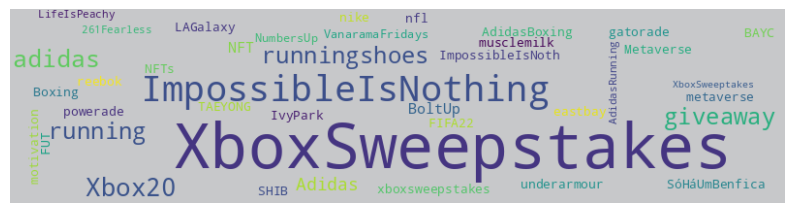

=============================================  LULULEMON  =============================================


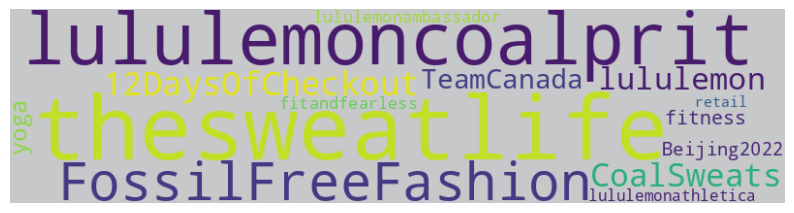

In [25]:
# ============ Function to create a wordcloud graph ====================
def generate_hashtag_wordcloud(df, brand, threshold):
    hashtags = []
    for text in df['full_text']:
        if isinstance(text, str):
            hashtags.extend(re.findall(r"#(\w+)", text))

    hashtag_counts = Counter(hashtags)
    filtered_hashtags = {tag: count for tag, count in hashtag_counts.items() if count >= threshold}

    wordcloud = WordCloud(width=800, height=200,background_color='#c7c8ca')
    wordcloud.generate_from_frequencies(filtered_hashtags)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

print('=============================================  ADIDAS  ================================================')
generate_hashtag_wordcloud(data_tweet_adidas, "Adidas", threshold=50)
print('=============================================  LULULEMON  =============================================')
generate_hashtag_wordcloud(data_tweet_lululemon, "Lululemon", threshold=10)

#### Removing retweets, numbers and other characters to reduce noise

In [26]:
# ============ Cleaning data ====================
# Stop words + irrelevant words
stop_words = set(stopwords.words('english'))
noise_words=['think','want','need','point','reason','expect','watch','live','file','care','morning','help','away','join','lower','talk','feel','everyday']
stop_words.update(noise_words)
p.set_options(p.OPT.URL, p.OPT.EMOJI,p.OPT.MENTION,p.OPT.SMILEY,p.OPT.NUMBER)

def clean_text(text):
    text = p.clean(text)
    text = text.strip().lower()
    # Remove retweets
    if text.startswith("rt"):
        return ""
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove words with repeated letters
    text = re.sub(r'(.)\1{2,}', r'\1', text)
    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text)
    # Remove punctuation
    text = re.sub(r'[^\w\s]', ' ', text)
    # Remove stopwords
    words = text.split()
    filtered_words = [w for w in words if not w in stop_words and len(w)>2]
    text = " ".join(filtered_words)

    return text

# Apply the cleaning function to the 'full_text' column
# FOR ADIDAS
data_tweet_adidas['cleaned_text'] = data_tweet_adidas['full_text'].apply(clean_text)
data_tweet_adidas = data_tweet_adidas[data_tweet_adidas['cleaned_text'].str.strip() != ""]
print(data_tweet_adidas.shape)
# FOR LULULEMON
data_tweet_lululemon['cleaned_text'] = data_tweet_lululemon['full_text'].apply(clean_text)
data_tweet_lululemon = data_tweet_lululemon[data_tweet_lululemon['cleaned_text'].str.strip() != ""]
print(data_tweet_lululemon.shape)

(16313, 4)
(4483, 4)


#### Creating bigrams

Bigrams were used to improve topic quality by capturing common word pairs that carry more specific meaning than individual words. Since tweets are short and often include key phrases like product names or expressions, using bigrams helps the LDA model identify more coherent and interpretable topics.

In [27]:
# CREATING BRIGRAMS FOR ADIDAS
adidas_texts = [[word for word in text.split() if len(word) >= 4] for text in data_tweet_adidas['cleaned_text']]
adidas_bigram = gensim.models.Phrases(adidas_texts, min_count=10, threshold=50)
adidas_bigram_model = gensim.models.phrases.Phraser(adidas_bigram)
# CREATING BRIGRAMS FOR LULULEMON
lululemon_texts = [[word for word in text.split() if len(word) >= 4] for text in data_tweet_lululemon['cleaned_text']]
lululemon_bigram = gensim.models.Phrases(lululemon_texts, min_count=10, threshold=50)
lululemon_bigram_model = gensim.models.phrases.Phraser(lululemon_bigram)

def make_bigrams(texts, bigram_model):
    return [bigram_model[doc] for doc in texts]

# Calculating bigrams
adidas_data_bigrams = make_bigrams(adidas_texts, adidas_bigram_model)
lululemon_data_bigrams = make_bigrams(lululemon_texts, lululemon_bigram_model)

#### Lemmatization

Lemmatization was chosen over stemming to ensure that words were reduced to their correct base forms while preserving their meaning. Unlike stemming, which can produce incomplete or non-existent words, lemmatization results in real, meaningful terms that improve the interpretability of the topics generated by the LDA model. This is especially useful in a context like social media, where clarity is important.

In [28]:
# ============ Function to apply Lemmatization ====================
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner']) # To speed up lemmatization
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# Do lemmatization keeping only noun, adj, vb, adv
adidas_data_lemmatized = lemmatization(adidas_data_bigrams)
lululemon_data_lemmatized = lemmatization(lululemon_data_bigrams)
# Boolean mask for non-empty docs
non_empty_docs_adidas = [len(doc) > 0 for doc in adidas_data_lemmatized]
non_empty_docs_lululemon = [len(doc) > 0 for doc in lululemon_data_lemmatized]
# Filtering Lemmatized data and original DataFrame
adidas_data_lemmatized = [doc for doc in adidas_data_lemmatized if len(doc) > 0]
data_tweet_adidas = data_tweet_adidas[non_empty_docs_adidas].reset_index(drop=True)

lululemon_data_lemmatized = [doc for doc in lululemon_data_lemmatized if len(doc) > 0]
data_tweet_lululemon = data_tweet_lululemon[non_empty_docs_lululemon].reset_index(drop=True)

/usr/local/lib/python3.11/dist-packages/spacy/util.py:910: UserWarning:

[W095] Model 'en_core_web_sm' (3.8.0) was trained with spaCy v3.8.0 and may not be 100% compatible with the current version (3.7.4). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate



### Creating elements for LDA

In [29]:
# Creating necesary elements for LDA
# FOR ADIDAS
adidas_dictionary = corpora.Dictionary(adidas_data_lemmatized)
print('Total Vocabulary Size:', len(adidas_dictionary))
adidas_texts_lemmatized = adidas_data_lemmatized
adidas_corpus = [adidas_dictionary.doc2bow(text) for text in adidas_texts_lemmatized]
# FOR LULULEMON
lululemon_dictionary = corpora.Dictionary(lululemon_data_lemmatized)
print('Total Vocabulary Size:', len(lululemon_dictionary))
lululemon_texts_lemmatized = lululemon_data_lemmatized
lululemon_corpus = [lululemon_dictionary.doc2bow(text) for text in lululemon_texts_lemmatized]

Total Vocabulary Size: 9997
Total Vocabulary Size: 4951


## Model Training & Evaluation

### Coherence LDA

#### Function to compute coherece values

In [30]:
# ============ Function to compute coherence values for different number of topics ====================
def compute_coherence_values_lda_model(dictionary, corpus, texts, limit, start=10, step=10):
    coherence_values_lda = []
    model_list_lda = []
    for num_topics in range(start, limit, step):
        lda_model = gensim.models.ldamodel.LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=num_topics,
            passes=10,
            random_state=0
            )

        model_list_lda.append(lda_model)
        coherencemodel_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values_lda.append(coherencemodel_lda.get_coherence())

    return model_list_lda, coherence_values_lda

#### Evaluating optimal numer of topics for ADIDAS

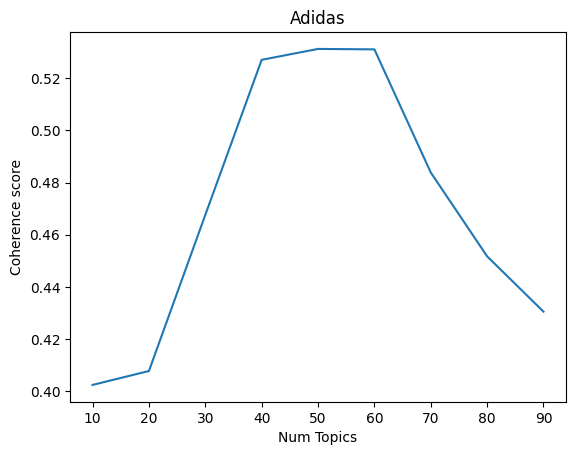

In [31]:
# Training Adidas LDA model with different number of topics
adidas_model_list_lda, adidas_coherence_values_lda = compute_coherence_values_lda_model(
    dictionary=adidas_dictionary,
    corpus=adidas_corpus,
    texts=adidas_data_lemmatized,
    limit=100
)

%matplotlib inline
# Show graph
start=10; limit=100; step=10;
x = range(start, limit, step)
y_lda = adidas_coherence_values_lda

plt.plot(x, y_lda, label='LDA_model')
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.title('Adidas')
plt.show()

In [32]:
# Training Adidas LDA model with optimal number of topics
adidas_lda_model_optimized = gensim.models.ldamodel.LdaModel(
    corpus=adidas_corpus,
    id2word=adidas_dictionary,
    num_topics=50,
    passes=10,
    random_state=0
    )

#### Evaluating optimal numer of topics for LULULEMON

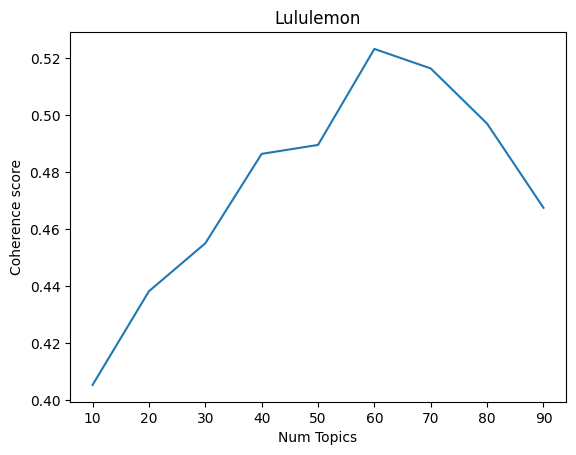

In [33]:
# Training Lululemon LDA model with different number of topics
lululemon_model_list_lda, lululemon_coherence_values_lda = compute_coherence_values_lda_model(
    dictionary=lululemon_dictionary,
    corpus=lululemon_corpus,
    texts=lululemon_data_lemmatized,
    limit=100
)

%matplotlib inline
# Show graph
start=10; limit=100; step=10;
x = range(start, limit, step)
y_lda = lululemon_coherence_values_lda

plt.plot(x, y_lda, label='LULULEMON_LDA_model')
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.title('Lululemon')
plt.show()

In [34]:
# Training Lululemon LDA model with optimal number of topics
lululemon_lda_model_optimized = gensim.models.ldamodel.LdaModel(
    corpus=lululemon_corpus,
    id2word=lululemon_dictionary,
    num_topics=60,
    passes=10,
    random_state=0
    )

### Getting some insights from dominant topics

#### Function to show dominant topics and plot them

In [35]:
# ============ Function to show and plot the 5 most dominant topics ====================
def get_and_plot_top_dominant_topics(lda_model, corpus, top_n, title="Top Dominant Topics"):
    # Get dominant topic per document
    dominant_topics = []
    for doc_bow in corpus:
        topics = lda_model.get_document_topics(doc_bow)
        dominant_topic = max(topics, key=lambda x: x[1])[0]
        dominant_topics.append(dominant_topic)
    # Count topic occurrences
    topic_counts = Counter(dominant_topics)
    # Sort and get top N topics
    sorted_topic_counts = dict(sorted(topic_counts.items(), key=lambda item: item[1], reverse=True))
    top_topics = list(sorted_topic_counts.items())[:top_n]
    # Print topics
    for topic_id, freq in top_topics:
        print(f"Topic {topic_id} – Frequency: {freq}")
        print(lda_model.print_topic(topic_id))
        print("-" * 60)
    # Plot
    topic_labels = [f'Topic {topic_id}' for topic_id, _ in top_topics]
    frequencies = [freq for _, freq in top_topics]
    plt.figure(figsize=(8, 4))
    plt.bar(topic_labels, frequencies)
    plt.xlabel('Topic')
    plt.ylabel('Number of Dominant Documents')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

#### Showing most important topics for ADIDAS

Topic 0 – Frequency: 1652
0.113*"player" + 0.099*"miss" + 0.075*"build" + 0.070*"classic" + 0.054*"break" + 0.048*"video" + 0.034*"allow" + 0.033*"young" + 0.031*"piece" + 0.031*"goal"
------------------------------------------------------------
Topic 38 – Frequency: 1072
0.513*"adida" + 0.222*"brand" + 0.073*"giveaway" + 0.059*"running_runningshoe" + 0.011*"country" + 0.011*"add" + 0.010*"exact" + 0.005*"weight" + 0.004*"mountain" + 0.004*"heavy"
------------------------------------------------------------
Topic 31 – Frequency: 557
0.439*"shoe" + 0.115*"buy" + 0.035*"market" + 0.030*"make" + 0.029*"announce" + 0.020*"smart" + 0.019*"rest" + 0.019*"especially" + 0.017*"focus" + 0.017*"speak"
------------------------------------------------------------
Topic 29 – Frequency: 504
0.298*"thank" + 0.108*"back" + 0.081*"sneaker" + 0.069*"call" + 0.046*"refund" + 0.042*"site" + 0.040*"deliver" + 0.036*"high" + 0.026*"major" + 0.021*"lasership"
-------------------------------------------------

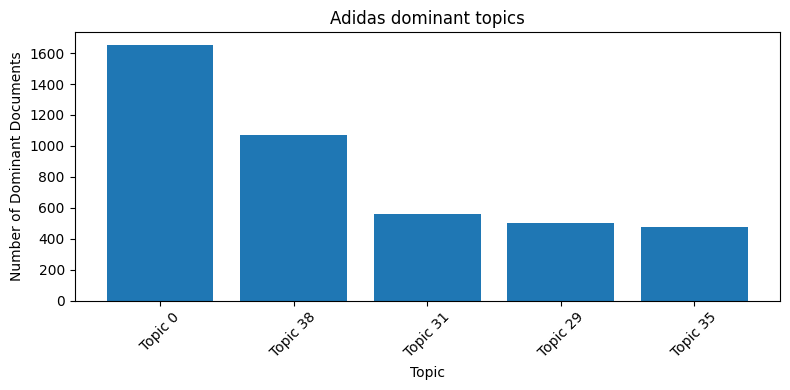

In [36]:
get_and_plot_top_dominant_topics(lda_model=adidas_lda_model_optimized, corpus=adidas_corpus, top_n=5, title='Adidas dominant topics')

#### Showing most important topics for LULULEMON

Topic 0 – Frequency: 323
0.219*"pant" + 0.196*"take_action" + 0.082*"coal_powere" + 0.076*"dont_coalsweat" + 0.076*"factories_produce" + 0.076*"practicing_preache" + 0.030*"wunder" + 0.029*"fact" + 0.025*"full" + 0.009*"believe"
------------------------------------------------------------
Topic 46 – Frequency: 182
0.150*"store" + 0.127*"legging" + 0.066*"today" + 0.061*"size" + 0.049*"return" + 0.044*"lululemon" + 0.041*"go" + 0.020*"pair" + 0.019*"exchange" + 0.019*"reach"
------------------------------------------------------------
Topic 25 – Frequency: 169
0.224*"thank" + 0.128*"great" + 0.117*"tell" + 0.079*"sale" + 0.057*"yoga" + 0.045*"spend" + 0.040*"make" + 0.034*"money" + 0.016*"know" + 0.013*"think"
------------------------------------------------------------
Topic 49 – Frequency: 158
0.108*"wait" + 0.077*"hour" + 0.065*"item" + 0.061*"order" + 0.060*"chat" + 0.045*"miss" + 0.044*"customer_service" + 0.035*"online" + 0.031*"sale" + 0.031*"reply"
------------------------------

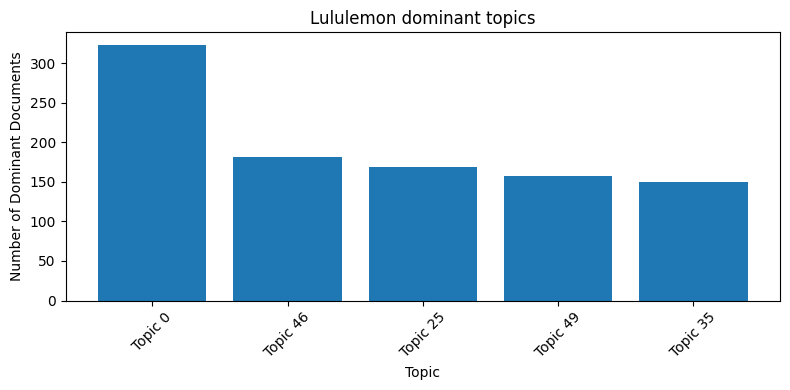

In [37]:
get_and_plot_top_dominant_topics(lda_model=lululemon_lda_model_optimized, corpus=lululemon_corpus, top_n=5,title='Lululemon dominant topics')

#### Creating a dictionary with most mentioned topics for both brands

In [38]:
# Creating a dictionary with each topic and a brief description
adidas_topics = {
    'topic 0': 'Player Development and Classic Moments',
    'topic 38': 'Adidas Brand Identity and Promotions',
    'topic 31': 'Shoe Launches and Consumer Interest',
    'topic 29': 'Thank You Messages and Delivery Issues',
    'topic 35': 'Style Praise and Product Satisfaction'
}
lululemon_topics = {
    'topic 0': 'Sustainability and Brand Responsibility',
    'topic 46': 'In-Store Experience and Product Exchanges',
    'topic 25': 'Customer Appreciation and Positive Shopping',
    'topic 49': 'Shipping Delays and Customer Service Issues',
    'topic 35': 'Healthcare and Hero Discounts'
}

## SENTIMENT ANALYSIS

#### Assigning each tweet its dominant topic

In [39]:
def assign_dominant_topic(df, corpus, lda_model):
    dominant_topics = []
    for bow in corpus:
        topic_probs = lda_model.get_document_topics(bow)
        dominant_topic = max(topic_probs, key=lambda x: x[1])[0]
        dominant_topics.append(dominant_topic)

    df['dominant_topic'] = dominant_topics
    return df

data_tweet_adidas = assign_dominant_topic(df=data_tweet_adidas,corpus=adidas_corpus,lda_model=adidas_lda_model_optimized)
data_tweet_lululemon = assign_dominant_topic(df=data_tweet_lululemon,corpus=lululemon_corpus,lda_model=lululemon_lda_model_optimized)
print(data_tweet_adidas.head())

  user.screen_name                                          full_text                 created_at                                       cleaned_text  dominant_topic
0        NateRuns5  @_christiankeith @d1vetsam @KicksFinder They a...  2021-10-01 07:37:16+00:00                                          available              24
1   BoysRevelacion  SELENA boosted up Puma stocks by 40%  Her part...  2021-10-01 11:00:25+00:00  selena boosted puma stocks partnership helped ...              17
2     datzallright  @adidasUS @adidasoriginals looks like this pro...  2021-10-01 10:05:13+00:00           looks like problem solver wearing slides              43
3  _christiankeith  @NateRuns5 @d1vetsam @KicksFinder @adidas Stil...  2021-10-01 07:51:43+00:00                               still says drop sept              23
4        TraeKicks  The Adidas Trae Young 1 “ICEE” is available on...  2021-10-01 09:43:02+00:00                   adidas trae young icee available              38


For sentiment analysis, VADER was selected because it is especially designed for social media text, such as tweets. Since the data consists of tweets related to Adidas and Lululemon, VADER is appropriate because it can understand informal language. In addition, VADER does not require any labeled data, which is useful in this case because the tweets are not annotated with sentiment. Also, VADER gives not only positive or negative labels, but also a compound score that helps to understand the overall sentiment of each tweet. For these reasons, VADER is a practical and effective tool for sentiment analysis in this context.

### Data cleaning for Sentiment Analysis

In [40]:
def clean_text_sentiment(text):
    text = p.clean(text)
    text = text.strip().lower()
    # Remove retweets
    if text.startswith("rt"):
        return ""
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove hashtags
    text = re.sub(r'#\w+', '', text)
    # Remove words with repeated letters
    text = re.sub(r'(.)\1{2,}', r'\1', text)
    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text)
    # Remove punctuation
    text = re.sub(r'[\"\'\(\)\[\]\{\}\|\<\>\=\+\*\\\/\^~`]', ' ', text)
    # Remove stopwords
    words = text.split()
    filtered_words = [w for w in words if not w in stop_words and len(w)>0]
    text = " ".join(filtered_words)

    return text

# Apply the cleaning function to the 'full_text' column
# FOR ADIDAS
data_tweet_adidas['sentiment_text'] = data_tweet_adidas['full_text'].apply(clean_text_sentiment)
print(data_tweet_adidas.shape)
# FOR LULULEMON
data_tweet_lululemon['sentiment_text'] = data_tweet_lululemon['full_text'].apply(clean_text_sentiment)
print(data_tweet_lululemon.shape)

(15371, 6)
(4321, 6)


### Performing VADER for sentiment analysis

In [41]:
sid = SentimentIntensityAnalyzer()

data_tweet_adidas['sentiment_scores'] = data_tweet_adidas['sentiment_text'].apply(lambda txt:sid.polarity_scores(txt))
data_tweet_adidas['polarity'] = data_tweet_adidas['sentiment_scores'].apply(lambda txt: txt['compound'])
data_tweet_adidas['sentiment'] = data_tweet_adidas['polarity'].apply(lambda txt: 'Positive' if txt>=0.05 else ('Negative' if txt<=-0.05 else 'Neutral'))

In [42]:
data_tweet_lululemon['sentiment_scores'] = data_tweet_lululemon['sentiment_text'].apply(lambda txt:sid.polarity_scores(txt))
data_tweet_lululemon['polarity'] = data_tweet_lululemon['sentiment_scores'].apply(lambda txt: txt['compound'])
data_tweet_lululemon['sentiment'] = data_tweet_lululemon['polarity'].apply(lambda txt: 'Positive' if txt>=0.05 else ('Negative' if txt<=-0.05 else 'Neutral'))

In [43]:
data_tweet_lululemon.head()

,user.screen_name,full_text,created_at,cleaned_text,dominant_topic,sentiment_text,sentiment_scores,polarity,sentiment
0,coleenlou1,@BillGarlandSpkr @LauraMcInnes7 @lululemon @je...,2021-10-01 11:58:05+00:00,thank bill happy fridaylets close week strong ...,17,"thank you, bill. happy fridaylets close week s...","{'neg': 0.0, 'neu': 0.297, 'pos': 0.703, 'comp...",0.9347,Positive
1,CoherenceMed,@EMRAnswers @ShereeseMayMba @stacy_hurt @Hassa...,2021-10-01 14:01:03+00:00,well nice great running yoga travel,25,"well nice great running, yoga, travel.","{'neg': 0.0, 'neu': 0.25, 'pos': 0.75, 'compou...",0.8402,Positive
2,IOwnItMovement,@BillGarlandSpkr @LauraMcInnes7 @lululemon @je...,2021-10-01 13:44:13+00:00,thanks bill cheers,25,thanks bill. cheers,"{'neg': 0.0, 'neu': 0.143, 'pos': 0.857, 'comp...",0.7184,Positive
3,soaibgrewal,@lululemon has been an early adopter of video ...,2021-10-01 14:31:16+00:00,early adopter video consultations fantastic job,43,early adopter video consultations fantastic job:,"{'neg': 0.0, 'neu': 0.581, 'pos': 0.419, 'comp...",0.5574,Positive
4,EMRAnswers,@CoherenceMed @ShereeseMayMba @stacy_hurt @Has...,2021-10-01 14:12:35+00:00,always great scuba top,25,always great. scuba top?,"{'neg': 0.0, 'neu': 0.253, 'pos': 0.747, 'comp...",0.7096,Positive


In [44]:
# Defining colors for sentiment
color_map = {
'Negative': 'crimson',
'Neutral': 'gray',
'Positive': 'seagreen'
}
def plot_brand_sentiment(df, brand_name):
    sentiment_counts = df['sentiment'].value_counts()
    colors = [color_map[sentiment] for sentiment in sentiment_counts.index]
    fig = go.Figure(data=[go.Bar(
        y=sentiment_counts.index,
        x=sentiment_counts.values,
        text=sentiment_counts.values,
        textposition='auto',
        orientation='h',
        marker_color=colors
    )])
    fig.update_layout(
        title=f'General Sentiment Towards {brand_name}',
        xaxis_title='Number of Tweets',
        height=240
    )
    fig.show()
plot_brand_sentiment(data_tweet_adidas, "Adidas")
plot_brand_sentiment(data_tweet_lululemon, "Lululemon")

In [45]:
# ============ Function to plot each dominant topics with its sentiment analysis ====================
def plot_topic_sentiment(df, topics, brand_name):
    sentiment_by_topic = df.groupby(['dominant_topic', 'sentiment']).size().unstack(fill_value=0)
    fig = go.Figure()
    for sentiment in ['Negative', 'Neutral', 'Positive']:
        fig.add_trace(go.Bar(
            y=list(topics.values()),
            x=sentiment_by_topic[sentiment].values,
            name=sentiment,
            orientation='h',
            marker_color=color_map[sentiment]
        ))
    fig.update_layout(
        title=f'Sentiment Analysis per Topic for {brand_name}',
        barmode='group',
        xaxis_title='Number of Tweets',
        yaxis_title='Topics',
        yaxis={'categoryorder':'total ascending'},
        height=380
    )

    fig.show()

plot_topic_sentiment(data_tweet_adidas, adidas_topics, "Adidas")
plot_topic_sentiment(data_tweet_lululemon,lululemon_topics,'Lululemon')